In [1]:
import pandas as pd
import torch
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import numpy as np
import karman
from karman.nn import *
import os
from torch.utils.data import Subset
from torch import nn
import argparse
from pyfiglet import Figlet
from termcolor import colored
from dataclasses import dataclass
from matplotlib import pyplot as plt
import imageio
from PIL import Image
import io
from IPython.display import Image
from astropy.time import Time
import astropy

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
time_and_position_based_features_to_calculate = [
    'all__day_of_year__[d]',
    'all__seconds_in_day__[s]',
    'all__sun_right_ascension__[rad]',
    'all__sun_declination__[rad]',
    'all__sidereal_time__[rad]',
    'tudelft_thermo__longitude__[deg]',
    'tudelft_thermo__latitude__[deg]'
    'tudelft_thermo__local_solar_time__[h]']

def create_datapoint(date, longitude, latitude, altitude):
    sample = {}
    date = pd.to_datetime(date)
    second_in_day = 3600*date.hour + 60*date.minute + date.second
    day_of_year = date.day_of_year
    t=Time(str(date),location=(f'{longitude}d', f'{latitude}d'))
    sunpos=astropy.coordinates.get_sun(t)
    sun_ra = sunpos.ra.rad
    sun_dec = sunpos.dec.rad
    side_real = t.sidereal_time('mean').rad
    lst = (second_in_day/3600.0 + longitude/15.)

    sample['all__seconds_in_day__[s]_sin'] = np.sin(2*np.pi*second_in_day/(24.0*60*60))
    sample['all__seconds_in_day__[s]_cos'] = np.cos(2*np.pi*second_in_day/(24.0*60*60))

    sample['all__day_of_year__[d]_sin'] = np.sin(2*np.pi*day_of_year/366.0)
    sample['all__day_of_year__[d]_cos'] = np.cos(2*np.pi*day_of_year/366.0)

    sample['all__sun_right_ascension__[rad]_sin'] = np.sin(sun_ra)
    sample['all__sun_right_ascension__[rad]_cos'] = np.cos(sun_ra)

    sample['all__sun_declination__[rad]_sin'] = np.sin(sun_dec)
    sample['all__sun_declination__[rad]_cos'] = np.cos(sun_dec)

    sample['all__sidereal_time__[rad]_sin'] = np.sin(side_real)
    sample['all__sidereal_time__[rad]_cos'] = np.cos(side_real)

    sample['tudelft_thermo__local_solar_time__[h]_sin'] = np.sin(2*np.pi*((lst + 12.0)/48))
    sample['tudelft_thermo__local_solar_time__[h]_cos'] = np.cos(2*np.pi*((lst + 12.0)/48))

    sample['tudelft_thermo__latitude__[deg]'] = float(latitude)

    sample['tudelft_thermo__longitude__[deg]_sin'] = np.sin(2*np.pi*((longitude + 180)/360.0))
    sample['tudelft_thermo__longitude__[deg]_cos'] = np.cos(2*np.pi*((longitude + 180)/360.0))

    sample['all__year__[y]'] = float(date.year)
    sample['tudelft_thermo__altitude__[m]'] = altitude
    return sample

In [3]:
model_path = '/home/jupyter/karman-project/best_model_NoFism2FlareAndDailyFeedForward_2022-09-08 08:21:32.592439_fold_2_seed_4'
#Stick to this convention 'best_model' is the model of interest.
model_opt = torch.load(model_path)['opt']

In [ ]:
if model_opt.model == 'NoFism2DailyFeedForward':
    model = NoFism2DailyFeedForward(
        dropout=model_opt.dropout,
        hidden_size=model_opt.hidden_size,
        out_features=model_opt.out_features
        ).to(dtype=torch.float32)
elif model_opt.model == 'NoFism2FlareAndDailyFeedForward':
    model = NoFism2FlareAndDailyFeedForward(
        dropout=model_opt.dropout,
        hidden_size=model_opt.hidden_size,
        out_features=model_opt.out_features
        ).to(dtype=torch.float32)

state_dict = torch.load(os.path.join(model_path))['state_dict']
#Sanitize state_dict key names
for key in list(state_dict.keys()):
    if key.startswith('module'):
    # Model was saved as dataparallel model
        # Remove 'module.' from start of key
        state_dict[key[7:]] = state_dict.pop(key)
    else:
        continue
# with torch.no_grad():
#     model.forward(batch)
model.load_state_dict(state_dict)
print('Loaded state dict')

In [24]:
model_opt

Namespace(batch_size=512, cyclical_features=True, data_directory='/home/jupyter/karman-project/data_directory', dropout=0.0, epochs=10, epochs_per_validation=1, features_to_exclude_fism2_daily_stan_bands='all__dates_datetime__', features_to_exclude_fism2_flare_stan_bands='all__dates_datetime__', features_to_exclude_omni='all__dates_datetime__,omniweb__id_for_imf_spacecraft__,omniweb__id_for_sw_plasma_spacecraft__,omniweb__#_of_points_in_imf_averages__,omniweb__#_of_points_in_plasma_averages__,omniweb__percent_of_interpolation__,omniweb__timeshift__[s],omniweb__rms_timeshift__[s],omniweb__rms_min_variance__[s**2],omniweb__time_btwn_observations__[s],omniweb__rms_sd_b_scalar__[nT],omniweb__rms_sd_b_field_vector__[nT],omniweb__flow_pressure__[nPa],omniweb__electric_field__[mV/m],omniweb__plasma_beta__,omniweb__alfven_mach_number__,omniweb__magnetosonic_mach_number__,omniweb__s/cx_gse__[Re],omniweb__s/cy_gse__[Re],omniweb__s/cz_gse__[Re]', features_to_exclude_thermo='all__dates_datetime__,

In [64]:
model_dataset = karman.ThermosphericDensityDataset(
    directory=model_opt.data_directory,
    lag_minutes_omni=model_opt.lag_minutes_omni,
    lag_minutes_fism2_flare_stan_bands=model_opt.lag_fism2_minutes_flare_stan_bands,
    lag_minutes_fism2_daily_stan_bands=model_opt.lag_fism2_minutes_daily_stan_bands,
    omni_resolution=model_opt.omni_resolution,
    fism2_flare_stan_bands_resolution=model_opt.fism2_flare_stan_bands_resolution,
    fism2_daily_stan_bands_resolution=model_opt.fism2_daily_stan_bands_resolution,
    features_to_exclude_thermo=model_opt.features_to_exclude_thermo.split(','),
    features_to_exclude_omni=model_opt.features_to_exclude_omni.split(','),
    features_to_exclude_fism2_flare_stan_bands=model_opt.features_to_exclude_fism2_flare_stan_bands.split(','),
    features_to_exclude_fism2_daily_stan_bands=model_opt.features_to_exclude_fism2_daily_stan_bands.split(','),
    create_cyclical_features=model_opt.cyclical_features,
    max_altitude=model_opt.max_altitude
)

model_dataset._set_indices(test_month_idx=[2], validation_month_idx=[4])

Loading Omni.
Loading FISM2 Flare Stan bands.
Loading FISM2 Daily Stan bands.
Creating thermospheric density dataset
Creating cyclical features
Used features: Index(['all__day_of_year__[d]', 'all__year__[y]', 'all__seconds_in_day__[s]',
       'tudelft_thermo__altitude__[m]', 'tudelft_thermo__longitude__[deg]',
       'tudelft_thermo__latitude__[deg]',
       'tudelft_thermo__local_solar_time__[h]',
       'space_environment_technologies__f107_average__',
       'space_environment_technologies__f107_obs__',
       'celestrack__ap_average__', 'celestrack__ap_h_0__',
       'celestrack__ap_h_1__', 'celestrack__ap_h_2__', 'celestrack__ap_h_3__',
       'celestrack__ap_h_4__', 'celestrack__ap_h_5__', 'celestrack__ap_h_6__',
       'all__sun_right_ascension__[rad]', 'all__sun_declination__[rad]',
       'all__sidereal_time__[rad]',
       'space_environment_technologies__s107_obs__',
       'space_environment_technologies__s107_average__',
       'space_environment_technologies__m107_obs__'

17 years to iterate through.: 100%|██████████| 17/17 [01:50<00:00,  6.52s/it]


Train size: 27719788
Validation size: 3011830
Test size: 2575188


In [61]:
space_x_end = pd.to_datetime('2022-03-05')
space_x_start = pd.to_datetime('2022-01-03')

In [68]:
#have to do it like this to keep the correct scaler from the model run.
space_x_dataset = karman.ThermosphericDensityDataset(
    directory=model_opt.data_directory,
    lag_minutes_omni=model_opt.lag_minutes_omni,
    lag_minutes_fism2_flare_stan_bands=model_opt.lag_fism2_minutes_flare_stan_bands,
    omni_resolution=model_opt.omni_resolution,
    fism2_flare_stan_bands_resolution=model_opt.fism2_flare_stan_bands_resolution,
    fism2_daily_stan_bands_resolution=model_opt.fism2_daily_stan_bands_resolution,
    features_to_exclude_thermo=model_opt.features_to_exclude_thermo.split(','),
    features_to_exclude_omni=model_opt.features_to_exclude_omni.split(','),
    features_to_exclude_fism2_flare_stan_bands=model_opt.features_to_exclude_fism2_flare_stan_bands.split(','),
    features_to_exclude_fism2_daily_stan_bands=model_opt.features_to_exclude_fism2_daily_stan_bands.split(','),
    create_cyclical_features=model_opt.cyclical_features,
    max_date=model_dataset.max_date,
    min_date=model_dataset.min_date,
    omni_scaler=model_dataset.time_series_data['omni']['scaler'],
    thermo_scaler=model_dataset.data_thermo['scaler'],
    fism2_flare_scaler=model_dataset.time_series_data['fism2_flare_stan_bands']['scaler'],
    fism2_daily_scaler=model_dataset.time_series_data['fism2_daily_stan_bands']['scaler']
)
space_x_dataset.thermospheric_density = space_x_dataset.data_thermo['data']['tudelft_thermo__ground_truth_thermospheric_density__[kg/m**3]'].values
thermospheric_density_log=np.log(space_x_dataset.thermospheric_density*1e12)
space_x_dataset.thermospheric_density_log_min = model_dataset.thermospheric_density_log_min
space_x_dataset.thermospheric_density_log_max = model_dataset.thermospheric_density_log_max
space_x_dataset.thermospheric_density = space_x_dataset.minmax_normalize(
    thermospheric_density_log,
    space_x_dataset.thermospheric_density_log_min,
    space_x_dataset.thermospheric_density_log_max)
space_x_dataset.thermospheric_density = torch.tensor(space_x_dataset.thermospheric_density).to(dtype=torch.float32).detach()
space_x_dataset._set_indices(test_month_idx=[2], validation_month_idx=[4])


Loading Omni.
Loading FISM2 Flare Stan bands.
Loading FISM2 Daily Stan bands.
Creating thermospheric density dataset
Creating cyclical features
Used features: Index(['all__day_of_year__[d]', 'all__year__[y]', 'all__seconds_in_day__[s]',
       'tudelft_thermo__altitude__[m]', 'tudelft_thermo__longitude__[deg]',
       'tudelft_thermo__latitude__[deg]',
       'tudelft_thermo__local_solar_time__[h]',
       'space_environment_technologies__f107_average__',
       'space_environment_technologies__f107_obs__',
       'celestrack__ap_average__', 'celestrack__ap_h_0__',
       'celestrack__ap_h_1__', 'celestrack__ap_h_2__', 'celestrack__ap_h_3__',
       'celestrack__ap_h_4__', 'celestrack__ap_h_5__', 'celestrack__ap_h_6__',
       'all__sun_right_ascension__[rad]', 'all__sun_declination__[rad]',
       'all__sidereal_time__[rad]',
       'space_environment_technologies__s107_obs__',
       'space_environment_technologies__s107_average__',
       'space_environment_technologies__m107_obs__'

In [67]:
from karman import Benchmark
benchmark = Benchmark(batch_size=1024, num_workers=15, model_name='space_x', output_directory='/home/jupyter/karman-project/output_directory')
dataset = model_dataset
model_dataset._set_indices(test_month_idx=[2], validation_month_idx=[4])
# dataset.test_indices = list(dataset.data_thermo['data'].index)
model = model.cuda()
results = benchmark.evaluate_model(dataset, model)
results


Creating training, validation and test sets.


17 years to iterate through.: 100%|██████████| 17/17 [01:53<00:00,  6.70s/it]


Train size: 27719788
Validation size: 3011830
Test size: 2575188


100%|██████████| 2515/2515 [01:27<00:00, 28.67it/s]


Ignoring outliers...
Removed 14 entries with outlier densities below 1e-17
Evaluating Storm Condition Results.
Saving results to /home/jupyter/karman-project/output_directory/space_x_results.csv


,Model,Metric Value,Condition,Support,Metric Type
0,JB08,4.103101e-12,1. (0-15) Quiet,2207877,RMSE
1,JB08,4.346949e+01,1. (0-15) Quiet,2207877,MAPE
2,Nrlmsise,3.768750e-12,1. (0-15) Quiet,2207877,RMSE
3,Nrlmsise,6.976567e+01,1. (0-15) Quiet,2207877,MAPE
4,space_x,1.813437e-12,1. (0-15) Quiet,2207877,RMSE
...,...,...,...,...,...
67,JB08,4.071467e+01,No condition,2575174,MAPE
68,Nrlmsise,4.187561e-12,No condition,2575174,RMSE
69,Nrlmsise,6.317878e+01,No condition,2575174,MAPE
70,space_x,2.291341e-12,No condition,2575174,RMSE


In [55]:
from karman import Benchmark
benchmark = Benchmark(batch_size=512, num_workers=10, model_name='space_x', output_directory='/home/jupyter/karman-project/output_directory')
dataset = model_dataset
dataset.test_indices = list(dataset.data_thermo['data'].index)[0:1000000]
model = model.cuda()
results = benchmark.evaluate_model(dataset, model)
results

100%|██████████| 1954/1954 [00:38<00:00, 50.41it/s]


Ignoring outliers...
Removed 0 entries with outlier densities below 1e-17
Evaluating Storm Condition Results.


/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Saving results to /home/jupyter/karman-project/output_directory/space_x_results.csv


,Model,Metric Value,Condition,Support,Metric Type
0,JB08,3.256893e-13,1. (0-15) Quiet,785520,RMSE
1,JB08,1.778341e+01,1. (0-15) Quiet,785520,MAPE
2,Nrlmsise,4.538663e-13,1. (0-15) Quiet,785520,RMSE
3,Nrlmsise,3.021333e+01,1. (0-15) Quiet,785520,MAPE
4,space_x,1.686204e-13,1. (0-15) Quiet,785520,RMSE
...,...,...,...,...,...
67,JB08,1.900340e+01,No condition,1000000,MAPE
68,Nrlmsise,4.996820e-13,No condition,1000000,RMSE
69,Nrlmsise,3.042095e+01,No condition,1000000,MAPE
70,space_x,2.105136e-13,No condition,1000000,RMSE


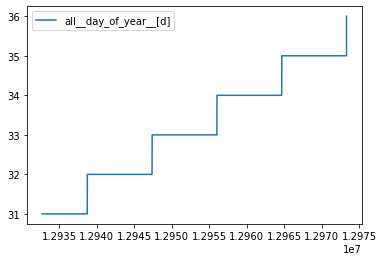

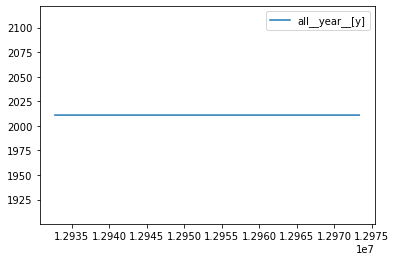

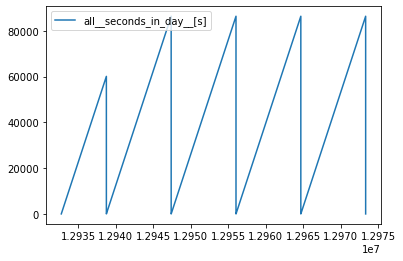

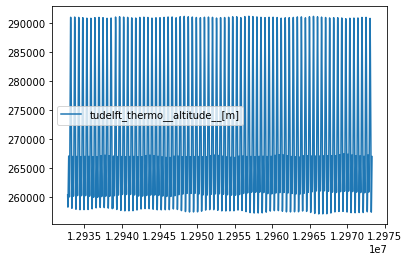

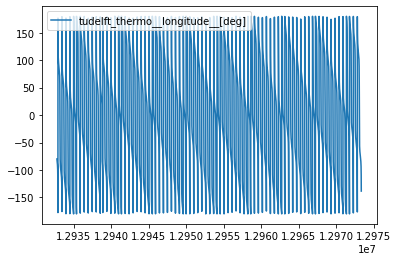

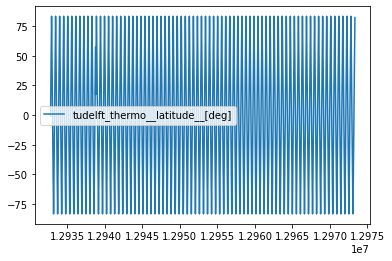

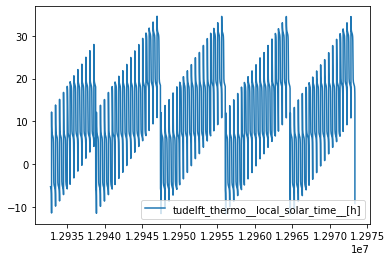

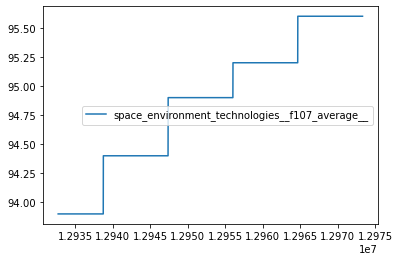

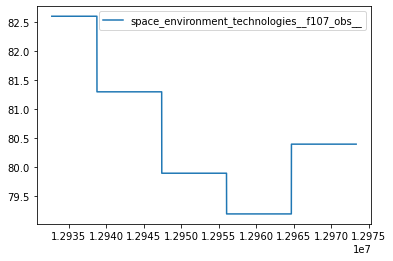

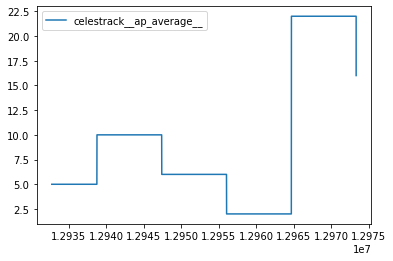

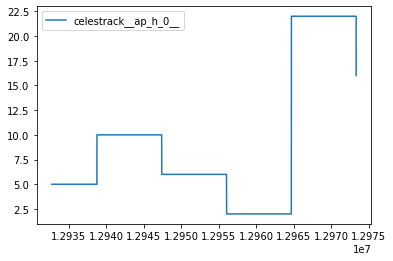

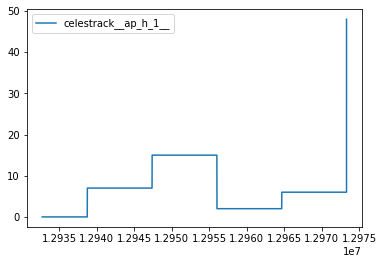

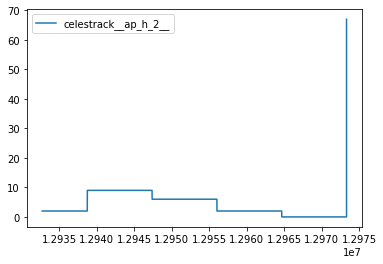

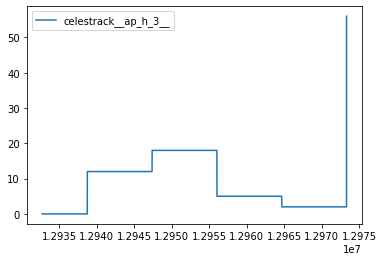

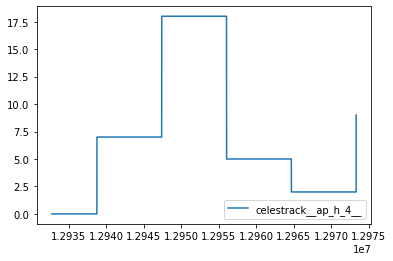

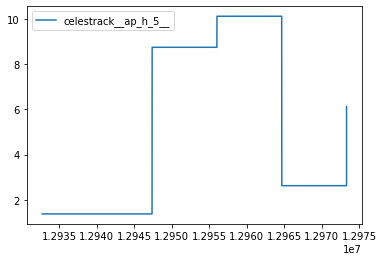

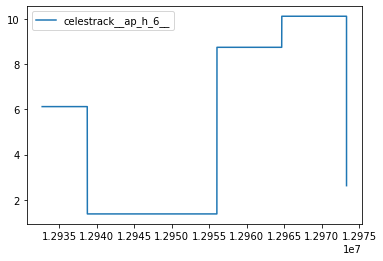

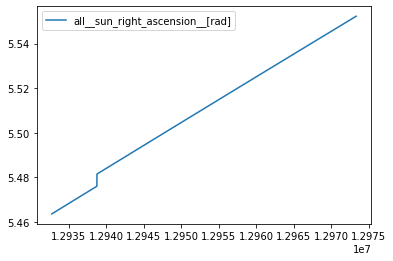

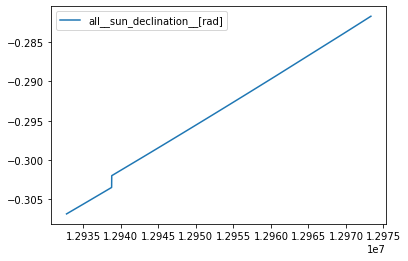

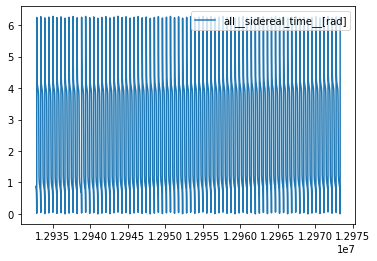

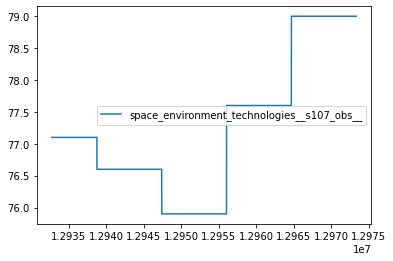

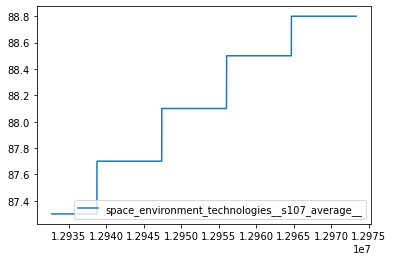

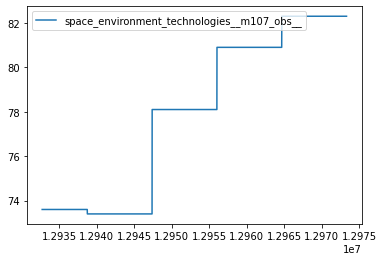

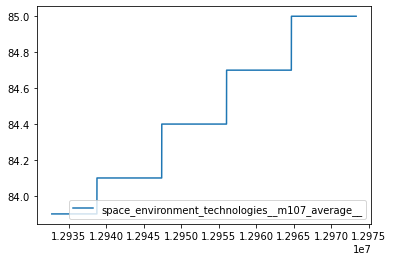

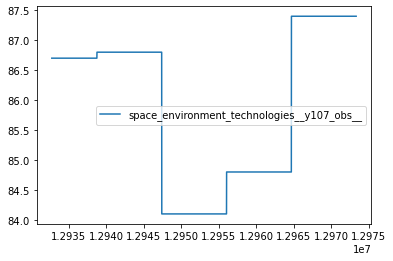

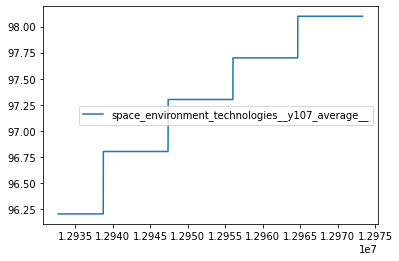

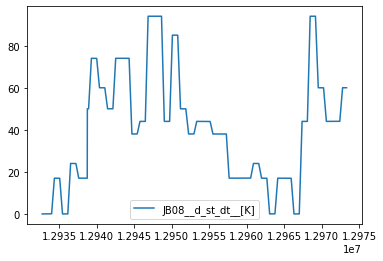

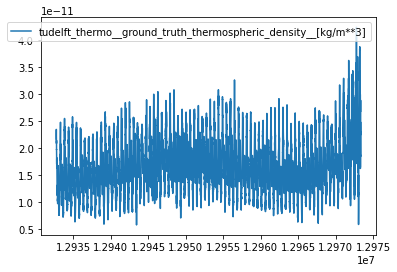

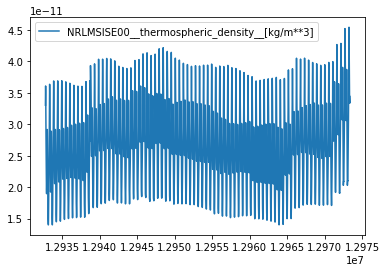

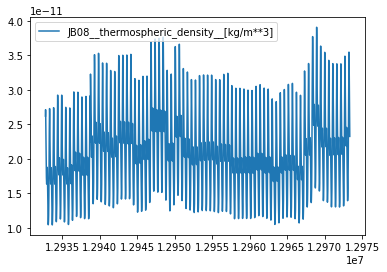

TypeError: no numeric data to plot

In [34]:
for col in model_dataset.data_thermo['data'].columns:
    indices_find = ((model_dataset.data_thermo['data']['all__dates_datetime__'] > pd.to_datetime('2011-01-31')) & (model_dataset.data_thermo['data']['all__dates_datetime__'] <= pd.to_datetime('2011-02-05')))
    model_dataset.data_thermo['data'].loc[indices_find, :].plot(y=col)
    plt.show()

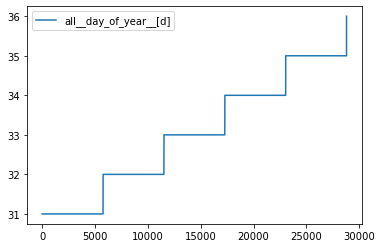

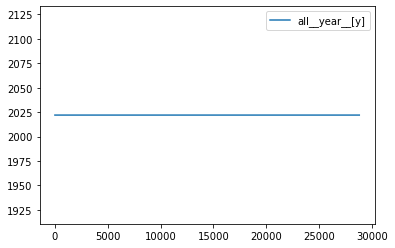

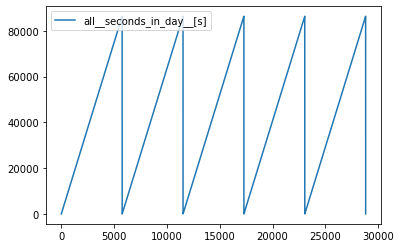

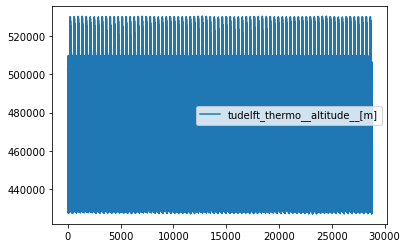

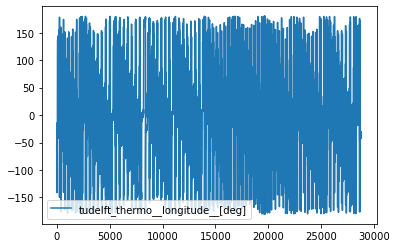

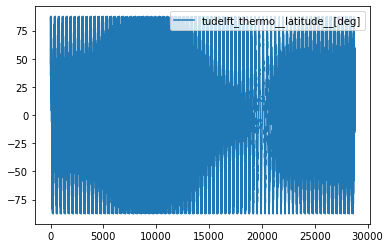

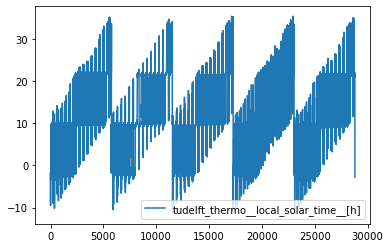

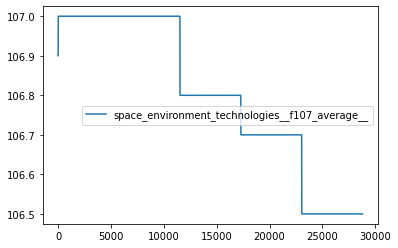

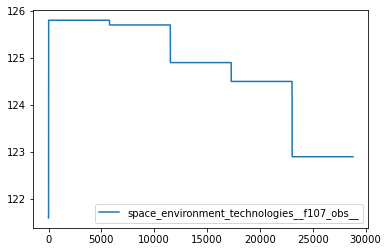

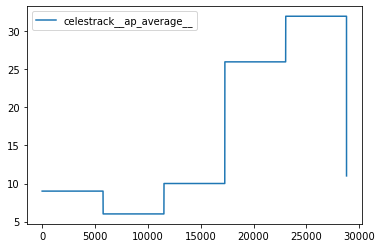

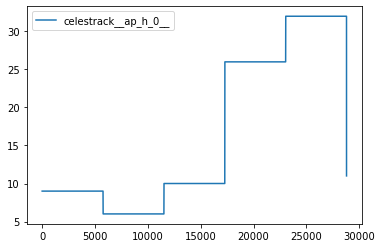

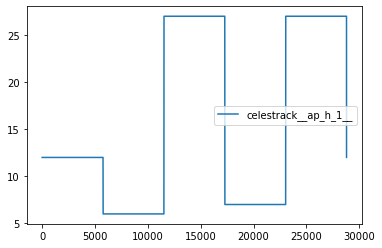

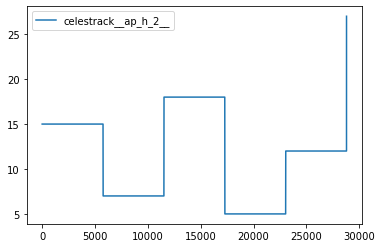

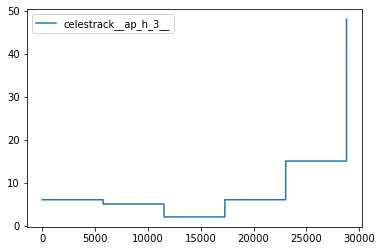

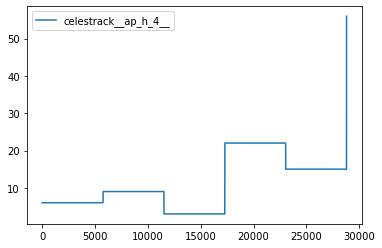

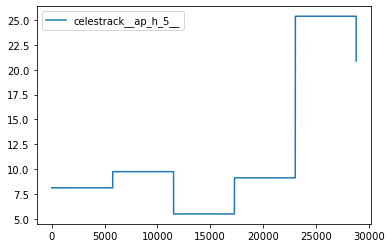

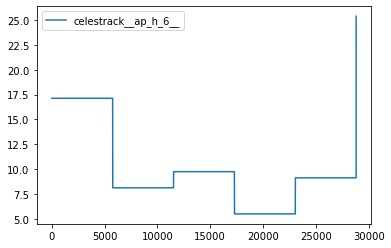

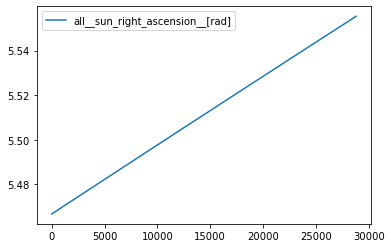

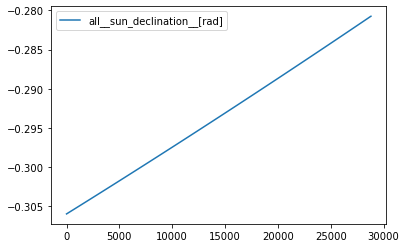

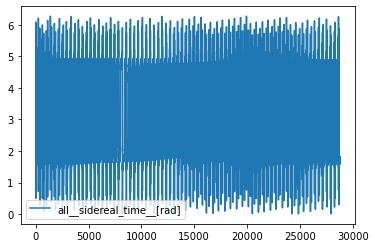

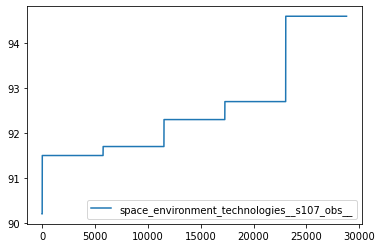

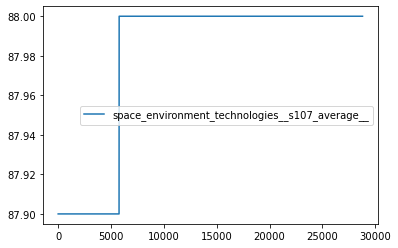

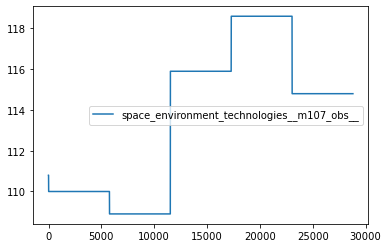

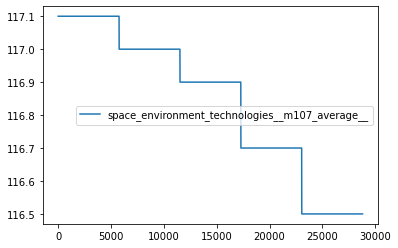

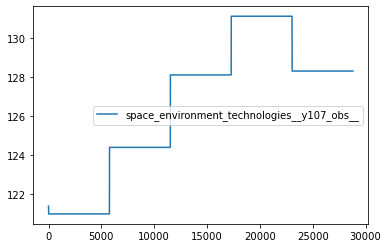

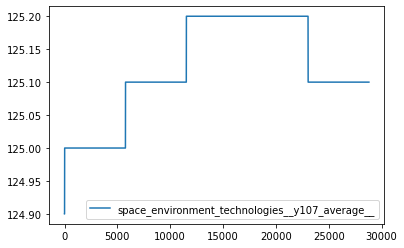

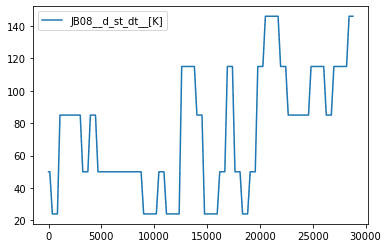

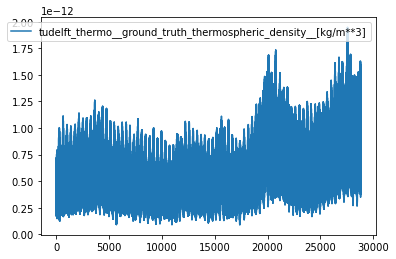

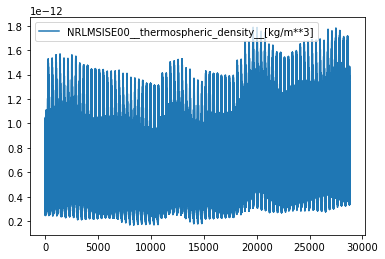

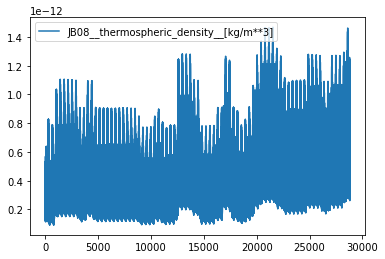

TypeError: no numeric data to plot

In [30]:
for col in space_x_dataset.data_thermo['data'].columns:
    space_x_dataset.data_thermo['data'].plot(y=col)
    plt.show()

In [20]:
from tqdm import tqdm
date_start = '2022-01-01 00:00:00'
date_end = '2022-03-01 00:00:00'
densities = []
dataframe = pd.DataFrame(columns=['date', 'density'])
dates = list(pd.date_range(start=date_start, end=date_end, freq='360T'))

for date in tqdm(dates):
    latitude = 0
    longitude = 0
    altitude = 210_000
    sample_data = create_datapoint(date, longitude, latitude, altitude)
    location_nearest_date = (space_x_dataset.data_thermo['data']['all__dates_datetime__']-date).abs().argsort()[:1]
    data = space_x_dataset.data_thermo['data'].iloc[location_nearest_date, :].drop(columns=model_opt.features_to_exclude_thermo.split(',')).copy()
    for key, value in sample_data.items():
        data.at[location_nearest_date, key] = value

    fism2_date_lag = date - pd.Timedelta(minutes=model_opt.lag_fism2_minutes_flare_stan_bands)
    fism2_flare_data = model_dataset.time_series_data['fism2_flare_stan_bands']['data'].loc[fism2_date_lag:date, :].copy()

    omni_date_lag = date - pd.Timedelta(minutes=model_opt.lag_minutes_omni)
    omni_data = model_dataset.time_series_data['omni']['data'].loc[omni_date_lag:date, :].copy()

    thermo_features = model_dataset.data_thermo['scaler'].transform(data)
    fism2_flare_features = model_dataset.time_series_data['fism2_flare_stan_bands']['scaler'].transform(fism2_flare_data)
    omni_features = model_dataset.time_series_data['omni']['scaler'].transform(omni_data)

    batch = {}
    batch['omni'] = torch.FloatTensor(omni_features).unsqueeze(0)
    batch['fism2_flare_stan_bands'] = torch.FloatTensor(fism2_flare_features).unsqueeze(0)
    batch['instantaneous_features'] = torch.FloatTensor(thermo_features.flatten()).unsqueeze(0)
    with torch.no_grad():
        output = model(batch)
    densities.append(model_dataset.unscale_density(output))
    dataframe = dataframe.append({'date': date, 'density': float(model_dataset.unscale_density(output).flatten())}, ignore_index=True)

dataframe.index = dates
dataframe

  0%|          | 0/237 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning

KeyboardInterrupt: 

In [15]:
indices_find = ((space_x_dataset.data_thermo['data']['all__dates_datetime__'] > pd.to_datetime('2022-01-31')) & (space_x_dataset.data_thermo['data']['all__dates_datetime__'] <= pd.to_datetime('2022-02-05')))
indices = space_x_dataset.data_thermo['data'][indices_find].index

for index in indices:
    sample = space_x_dataset.data_thermo['data']

,all__day_of_year__[d],all__year__[y],all__seconds_in_day__[s],tudelft_thermo__altitude__[m],tudelft_thermo__longitude__[deg],tudelft_thermo__latitude__[deg],tudelft_thermo__local_solar_time__[h],space_environment_technologies__f107_average__,space_environment_technologies__f107_obs__,celestrack__ap_average__,...,all__sun_right_ascension__[rad]_sin,all__sun_right_ascension__[rad]_cos,all__sun_declination__[rad]_sin,all__sun_declination__[rad]_cos,all__sidereal_time__[rad]_sin,all__sidereal_time__[rad]_cos,tudelft_thermo__longitude__[deg]_sin,tudelft_thermo__longitude__[deg]_cos,tudelft_thermo__local_solar_time__[h]_sin,tudelft_thermo__local_solar_time__[h]_cos
37451512,31.0,2022.0,30.0,502607.28125,-26.093552,37.315571,-1.731237,107.0,125.800003,9.0,...,-0.728729,0.684802,-0.301233,0.953551,0.969313,-0.245828,0.439838,-0.898077,0.974266,0.225403
37451513,31.0,2022.0,30.0,437840.93750,-101.575958,87.125786,-6.763397,107.0,125.800003,9.0,...,-0.728729,0.684802,-0.301233,0.953551,0.480964,0.876740,0.979660,0.200667,0.632253,0.774762
37451514,31.0,2022.0,60.0,437795.56250,-76.009743,85.941757,-5.050649,107.0,125.800003,9.0,...,-0.728725,0.684807,-0.301231,0.953551,0.813506,0.581556,0.970337,-0.241757,0.788735,0.614733
37451515,31.0,2022.0,60.0,502917.03125,-26.098240,39.221088,-1.723216,107.0,125.800003,9.0,...,-0.728725,0.684807,-0.301231,0.953551,0.968794,-0.247869,0.439912,-0.898041,0.974502,0.224380
37451516,31.0,2022.0,90.0,437719.59375,-63.410938,84.335686,-4.202396,107.0,125.800003,9.0,...,-0.728721,0.684811,-0.301230,0.953552,0.921620,0.388093,0.894240,-0.447588,0.852020,0.523510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37480307,35.0,2022.0,86340.0,505739.50000,-30.539839,55.925571,21.947344,106.5,122.900002,32.0,...,-0.665212,0.746654,-0.277082,0.960846,0.968857,-0.247620,0.508137,-0.861276,-0.964265,-0.264939
37480308,35.0,2022.0,86370.0,506096.78125,-30.416460,57.822212,21.963903,106.5,122.900002,32.0,...,-0.665207,0.746659,-0.277080,0.960847,0.967773,-0.251823,0.506282,-0.862368,-0.964837,-0.262847
37480309,35.0,2022.0,86370.0,431290.18750,-41.509212,-13.318653,21.224386,106.5,122.900002,32.0,...,-0.665207,0.746659,-0.277080,0.960847,0.998143,-0.060921,0.662741,-0.748849,-0.934901,-0.354907
37480310,36.0,2022.0,0.0,506445.96875,-30.265532,59.717686,-2.017702,106.5,122.900002,11.0,...,-0.665203,0.746663,-0.277078,0.960847,0.966548,-0.256487,0.504008,-0.863699,0.965126,0.261784


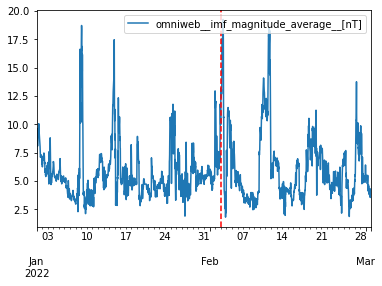

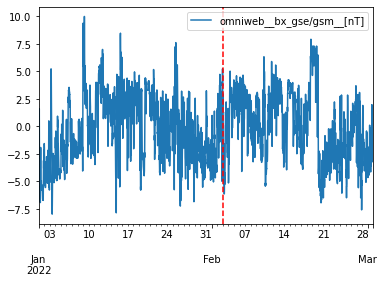

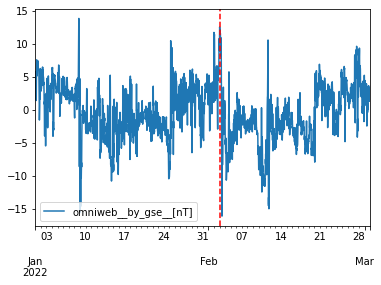

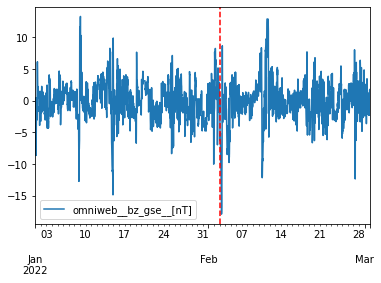

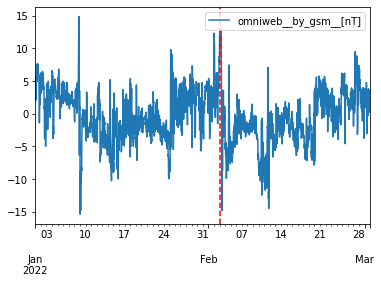

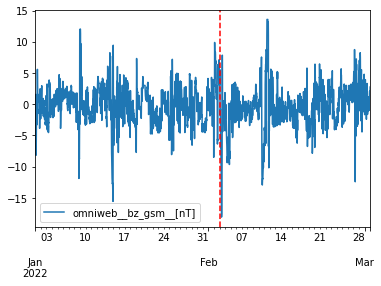

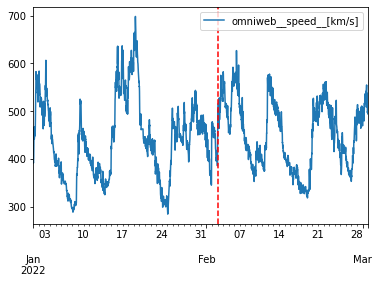

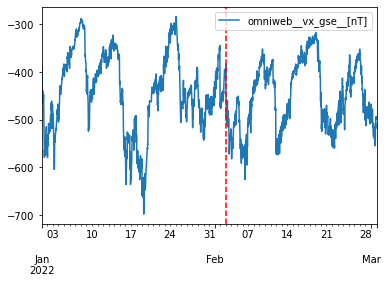

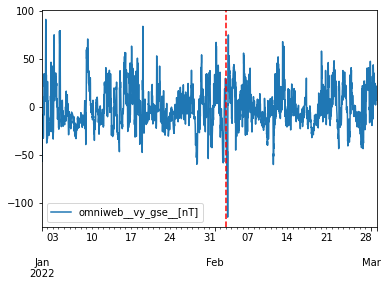

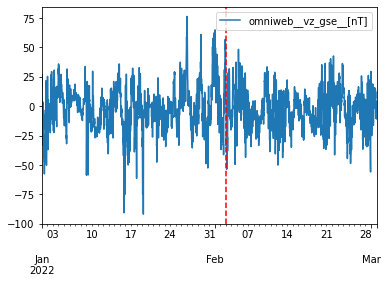

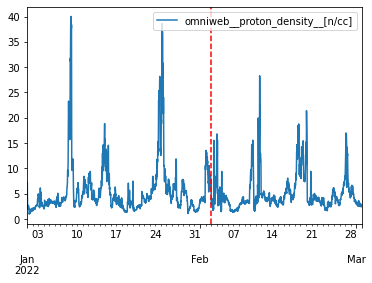

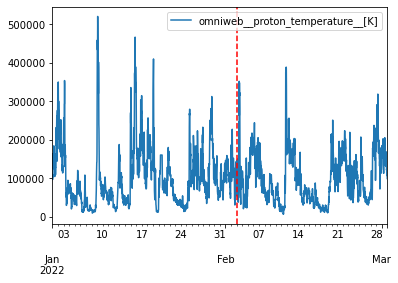

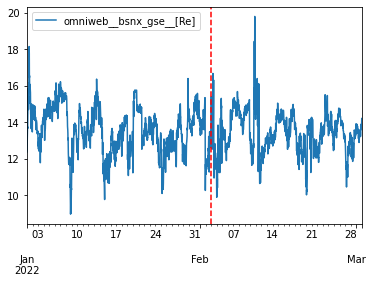

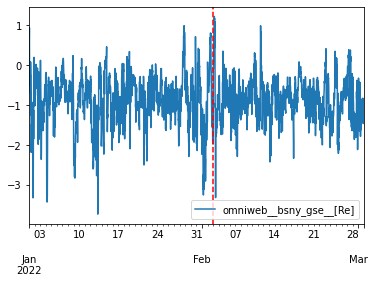

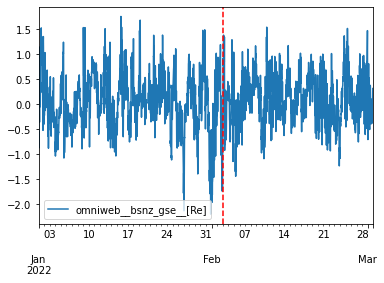

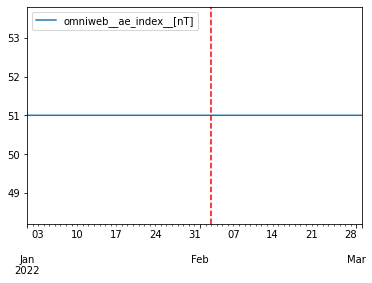

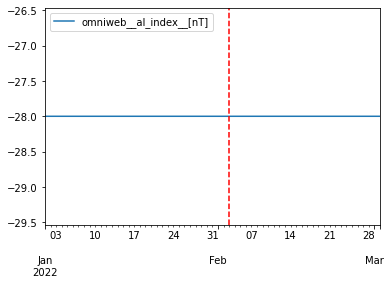

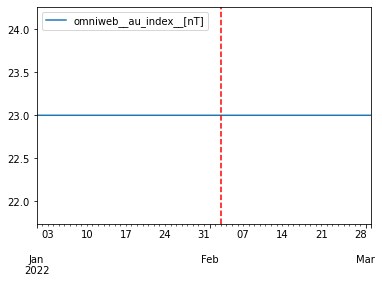

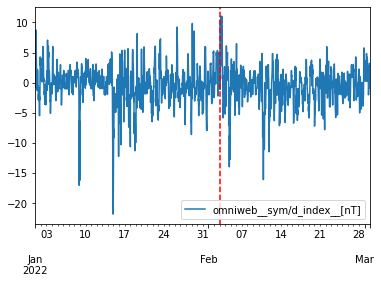

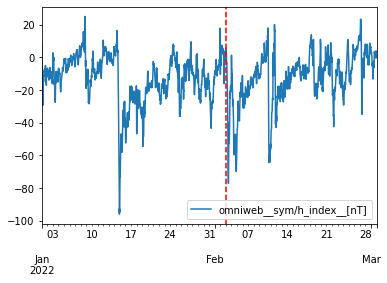

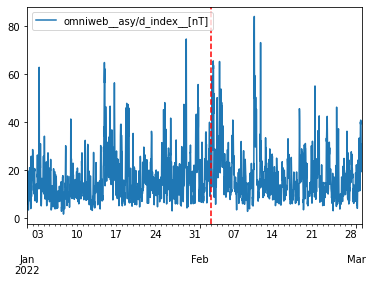

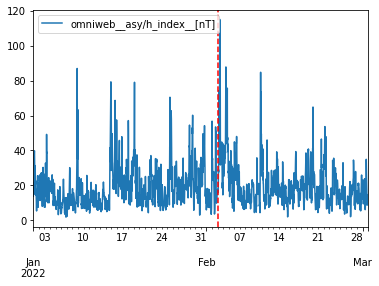

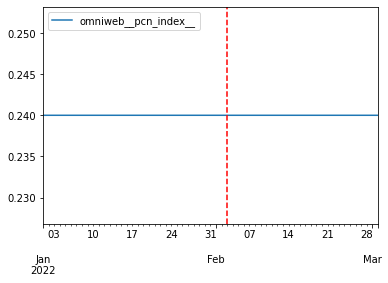

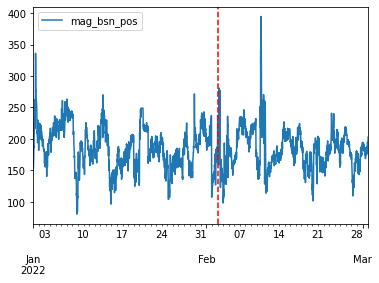

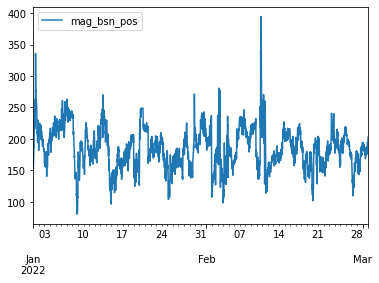

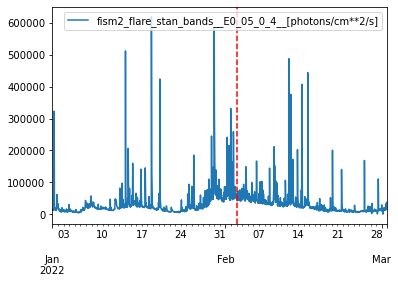

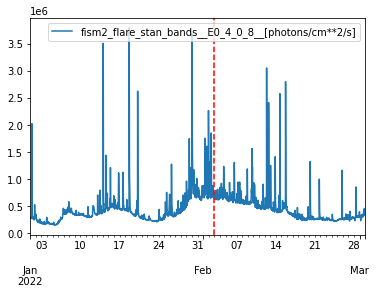

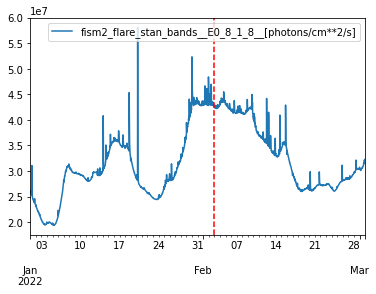

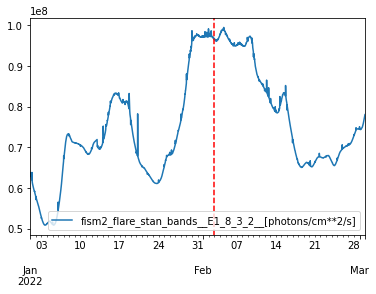

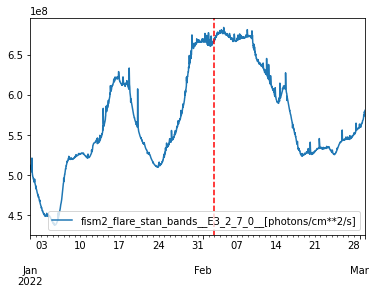

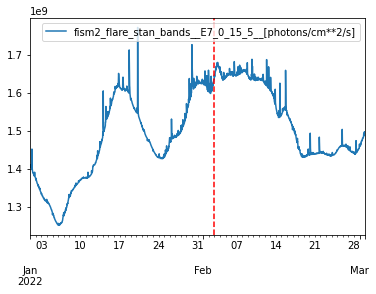

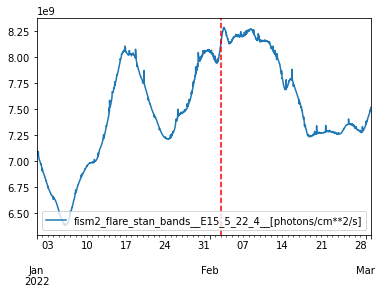

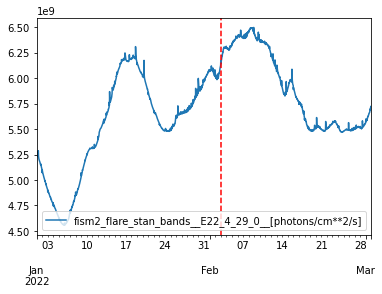

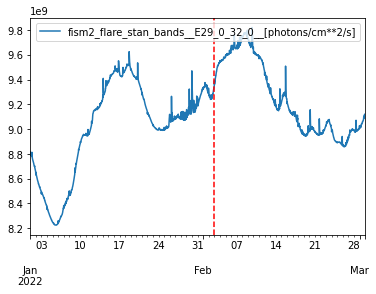

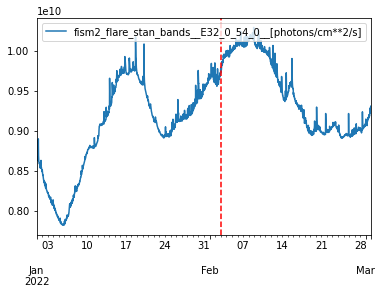

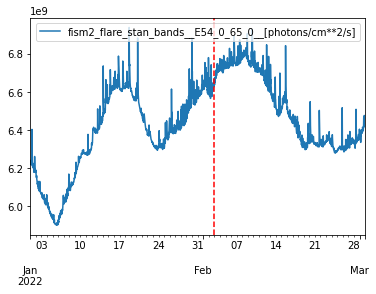

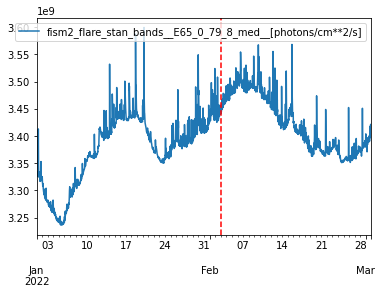

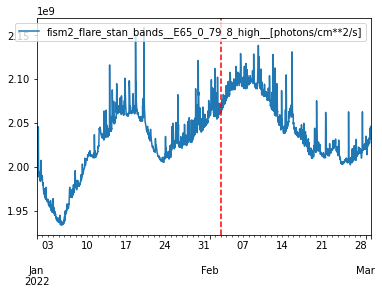

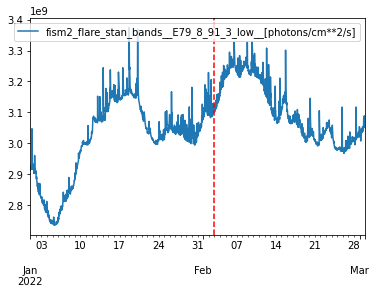

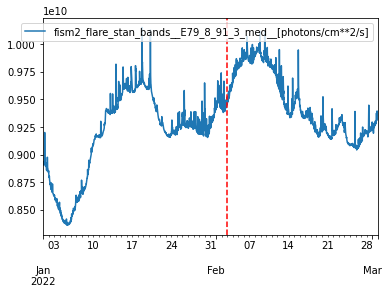

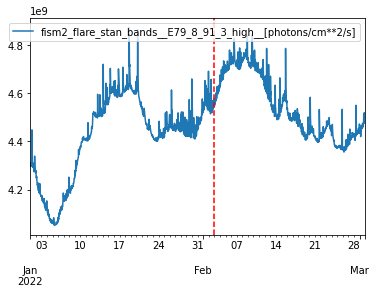

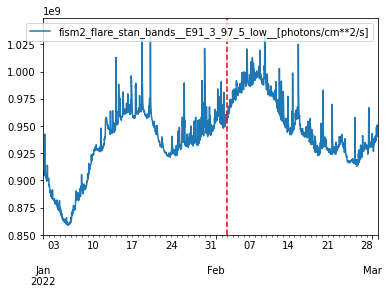

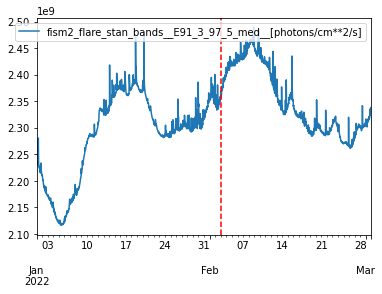

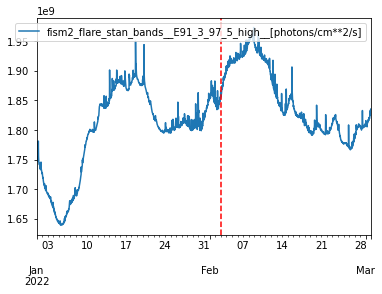

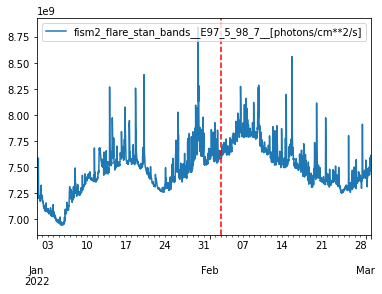

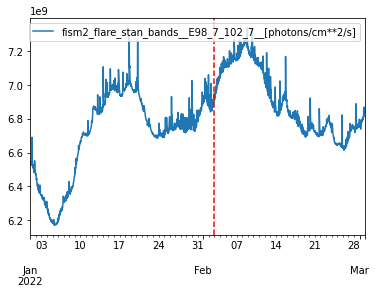

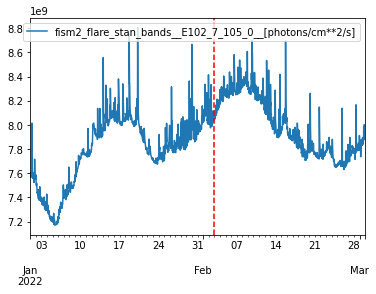

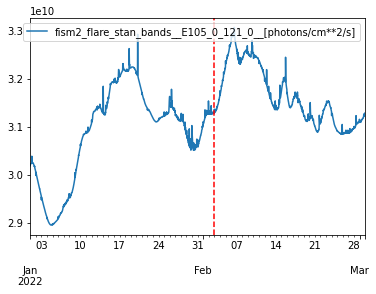

In [53]:
from matplotlib import pyplot as plt
date_start = '2022-01-01'
date_end = '2022-03-01'

for column in space_x_dataset.time_series_data['omni']['data'].columns:
    ax = space_x_dataset.time_series_data['omni']['data'].loc[date_start:date_end].plot(y=[column])
    ax.axvline("2022-02-03", color="red", linestyle="--")
    plt.xlabel('')
    plt.show()

space_x_dataset.time_series_data['omni']['data']['mag_bsn_pos'] = space_x_dataset.time_series_data['omni']['data']['omniweb__bsnz_gse__[Re]']**2 + \
    space_x_dataset.time_series_data['omni']['data']['omniweb__bsnx_gse__[Re]']**2 +\
    space_x_dataset.time_series_data['omni']['data']['omniweb__bsny_gse__[Re]']**2

space_x_dataset.time_series_data['omni']['data'].loc[date_start:date_end].plot(y=['mag_bsn_pos'])
plt.xlabel('')
plt.show()

for column in space_x_dataset.time_series_data['fism2_flare_stan_bands']['data'].columns:
    ax = space_x_dataset.time_series_data['fism2_flare_stan_bands']['data'].loc[date_start:date_end].plot(y=[column])
    ax.axvline("2022-02-03", color="red", linestyle="--")
    plt.xlabel('')
    plt.show()